In [43]:
import os

import pandas as pd
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim

import warnings
warnings.filterwarnings("ignore")


if not os.path.exists('data'):
    os.makedirs('data')

DATASET_OPTIONS = ["steel", "fetal_health"]
DATASET = "fetal_health"
SEED = 0 # Seed for reproducibility

# configure these to your liking like in the previous notebook
GS_RESULTS_FILE = 'results/gs_results.csv' # there has to be a results folder
SHOW_EXAMPLE = False # if you want to train an example of the model
SAVE_BEST_MODELS = False # if you want to save the best model


# Data Processing
## Loading the data

In [3]:

if DATASET == "steel":
    if not os.path.exists('data/steel'):
        os.makedirs('data/steel')
    if not os.path.exists('data/steel/steel.train'):
        # fetch dataset
        steel_plates_faults = fetch_ucirepo(id=198)

        # data (as pandas dataframes)
        X = steel_plates_faults.data.features
        y = steel_plates_faults.data.targets

        # preprocess the targets
        # put the class as the index of the 1 in the row
        y = y.idxmax(axis=1)

        # convert to numbers
        y = y.astype('category').cat.codes

        # split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # saving the data
        X_train.to_csv('data/steel/steel.train', index=False)
        X_test.to_csv('data/steel/steel.test', index=False)
        y_train.to_csv('data/steel/steel.train.target', index=False)
        y_test.to_csv('data/steel/steel.test.target', index=False)

        print('Data saved in data/steel/steel.train, data/steel/steel.test, data/steel/steel.train.target, data/steel/steel.test.target')
    else:
        print('Data already exists in data/steel/steel.train, data/steel/steel.test, data/steel/steel.train.target, data/steel/steel.test.target')

    # load the data
    X_train = pd.read_csv('data/steel/steel.train')
    X_test = pd.read_csv('data/steel/steel.test')
    y_train = pd.read_csv('data/steel/steel.train.target')
    y_test = pd.read_csv('data/steel/steel.test.target')

In [4]:
if DATASET == "fetal_health":
    if not os.path.exists('data/fetal_health'):
        os.makedirs('data/fetal_health')

    if not os.path.exists('data/fetal_health/fetal_health.train'):
        # this data is meant to have been downloaded from kaggle
        fetal_health = pd.read_csv('data/fetal_health/fetal_health.csv')

        # split data
        X = fetal_health.drop(columns='fetal_health')
        y = fetal_health['fetal_health']

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # saving the data
        X_train.to_csv('data/fetal_health/fetal_health.train', index=False)
        X_test.to_csv('data/fetal_health/fetal_health.test', index=False)
        y_train.to_csv('data/fetal_health/fetal_health.train.target', index=False)
        y_test.to_csv('data/fetal_health/fetal_health.test.target', index=False)

        print('Data saved in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target')
    else:
        print('Data already exists in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target')

    # load the data
    X_train = pd.read_csv('data/fetal_health/fetal_health.train')
    X_test = pd.read_csv('data/fetal_health/fetal_health.test')
    y_train = pd.read_csv('data/fetal_health/fetal_health.train.target')
    y_test = pd.read_csv('data/fetal_health/fetal_health.test.target')


Data already exists in data/fetal_health/fetal_health.train, data/fetal_health/fetal_health.test, data/fetal_health/fetal_health.train.target, data/fetal_health/fetal_health.test.target


In [5]:
print(f"Using dataset: {DATASET}")

Using dataset: fetal_health


In [6]:
# convert to numpy arrays
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

In [7]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE} device')

Using cuda device


## Pre-processing via normalization

In [8]:
# normalize the data
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_train = normalize(X_train)
X_test = normalize(X_test)

# extracting a validation set
VALIDATION_SIZE = 0.1
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=VALIDATION_SIZE)

# creating the tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)

y_train = torch.tensor(y_train, dtype=torch.int64)
y_val = torch.tensor(y_val, dtype=torch.int64)
y_test = torch.tensor(y_test, dtype=torch.int64)

# send to device
X_train = X_train.to(DEVICE)
X_val = X_val.to(DEVICE)
X_test = X_test.to(DEVICE)

y_train = y_train.to(DEVICE)
y_val = y_val.to(DEVICE)
y_test = y_test.to(DEVICE)

# create the dataset
BATCH_SIZE = 32
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model Development

## Model Implementations

In [9]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Multi-Layer Perceptron model with 3 hidden layers of 256, 128, and 64 neurons each
        """
        super(MLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        return self.softmax(x)

class DeepMLP(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Multi-Layer Perceptron model with 5 hidden layers of 512, 256, 128, 64, 32 neurons each
        """
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(32, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.model(x)
        return self.softmax(x)

class CNN(nn.Module):
    def __init__(self, input_size, output_size):
        """
        A Convolutional Neural Network model with 2 convolutional layers and 2 fully connected layers
        """
        super(CNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(64 * (input_size // 4), 128),
            nn.ReLU(),
            nn.Linear(128, output_size)
        )
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.model(x)
        return self.softmax(x)

## Example training loop

In [10]:
# hyperparameters
INPUT_SIZE = X_train.shape[1]
OUTPUT_SIZE = y_train.max() + 1
LEARNING_RATE = 0.0001
EPOCHS = 1000
LOGGING_EPOCHS = 50

In [11]:
# set the seed
torch.manual_seed(0)

if SHOW_EXAMPLE:

    # training the model
    model = MLP(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

    # Early stopping parameters
    early_stopping_patience = 100
    best_val_loss = float('inf')
    best_epoch = 0
    patience_counter = 0
    training_losses = []
    validation_losses = []

    for epoch in range(1, EPOCHS + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

        # scheduler.step(loss)

        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train)
            val_loss = criterion(model(X_val), y_val)
            test_loss = criterion(model(X_test), y_test)
            training_losses.append(float(train_loss))
            validation_losses.append(float(val_loss))
            
            if not epoch % LOGGING_EPOCHS:
                print(f'Epoch {epoch}/{EPOCHS} Train loss: {train_loss:.4f} Val loss: {val_loss:.4f} Test loss: {test_loss:.4f}')
            
            # Check for early stopping
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_epoch = epoch
                patience_counter = 0
            else:
                patience_counter += 1
                if patience_counter >= early_stopping_patience:
                    print(f'Early stopping at epoch {epoch}')
                    print(f'Best epoch: {best_epoch} with val loss: {best_val_loss:.4f}')
                    break

In [12]:
if SHOW_EXAMPLE:
    # graph the losses
    import matplotlib.pyplot as plt
    plt.plot(training_losses, label='Training loss')
    plt.plot(validation_losses, label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


In [13]:
from sklearn.metrics import classification_report

if SHOW_EXAMPLE:
    model.eval()
    with torch.no_grad():
        y_pred = model(X_test).argmax(dim=1)
        print(classification_report(y_test.cpu(), y_pred.cpu()))

## Grid search

In [14]:
# additional metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(y_true, y_pred):
    """
    Compute accuracy, precision, recall, and f1 score (the macro average)

    Args:
    y_true: true labels
    y_pred: predicted labels

    Returns:
    a dictionary with the computed metrics
    """

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    out = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }
    return out


In [15]:
def train_model(model_specs, data_specs, epochs, early_stopping_patience=100, seed=0, logging=True, metric_specs=None, return_model=False):
    """
    Regular training loop with early stopping

    model_specs: dict
        model: torch.nn.Module
        criterion: torch.nn.Module
        optimizer: torch.optim.Optimizer
        scheduler: torch.optim.lr_scheduler
        train_loader: torch.utils.data.DataLoader
        val_loader: torch.utils.data.DataLoader
    data_specs: dict
        X_train: torch.Tensor
        y_train: torch.Tensor
        X_val: torch.Tensor
        y_val: torch.Tensor
    epochs: int
        Number of epochs to train the model
    early_stopping_patience: int
        Number of epochs to wait before early stopping when the key metric does not improve
    seed: int
        Random seed
    logging: bool
        Whether to print the training and validation losses
    metric_specs: dict
        metrics: function
            A function that takes y_true and y_pred and returns a dictionary of metrics
        larger_is_better: bool
            Whether a larger value of the key metric is better
        key_metric: str
            The key metric to use for early stopping
    return_model: bool
        Whether to return the trained model
    """
    torch.manual_seed(seed)
    model = model_specs['model']
    criterion = model_specs['criterion']
    optimizer = model_specs['optimizer']
    scheduler = model_specs['scheduler']
    train_loader = model_specs['train_loader']
    val_loader = model_specs['val_loader']

    X_train = data_specs['X_train']
    y_train = data_specs['y_train']
    X_val = data_specs['X_val']
    y_val = data_specs['y_val']

    if metric_specs is not None:
        get_metrics = metric_specs['metrics']
        larger_is_better = metric_specs['larger_is_better']
        key_metric = metric_specs['key_metric']
    else:
        get_metrics = None
        larger_is_better = False
        key_metric = None


    best_metric = float('-inf') if larger_is_better else float('inf')
    best_epoch = 0
    patience_counter = 0
    training_losses = []
    validation_losses = []
    training_key_metrics = []
    validation_key_metrics = []


    for epoch in range(1, epochs + 1):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(DEVICE), y_batch.to(DEVICE)

            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
        
        if scheduler is not None:
            scheduler.step(loss)

        model.eval()
        with torch.no_grad():
            train_loss = criterion(model(X_train), y_train)
            val_loss = criterion(model(X_val), y_val)
            training_losses.append(float(train_loss))
            validation_losses.append(float(val_loss))

            if metric_specs is not None:
                y_train_pred = model(X_train)
                y_val_pred = model(X_val)
                # evaluate the metrics on cpu
                metrics_train = get_metrics(y_train.cpu().numpy(), y_train_pred.cpu().argmax(dim=1).numpy())
                metrics_val = get_metrics(y_val.cpu().numpy(), y_val_pred.cpu().argmax(dim=1).numpy())
            
            if logging and epoch % 50 == 0:
                print(f'Epoch {epoch}/{epochs} Train loss: {train_loss:.4f} Val loss: {val_loss:.4f} ', end='')
                if metric_specs is not None:
                      print(f'Train {key_metric}: {metrics_train[key_metric]:.4f} Val {key_metric}: {metrics_val[key_metric]:.4f}')
                else:
                    print('')

            # Check for early stopping
            if metric_specs is not None:
                if larger_is_better:
                    val_metric = metrics_val[key_metric]
                    if val_metric > best_metric:
                        best_metric = val_metric
                        best_epoch = epoch
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            if logging:
                                print(f'Early stopping at epoch {epoch}')
                                print(f'Best epoch: {best_epoch} with val {key_metric}: {best_metric:.4f}')
                            break
                else:
                    val_metric = metrics_val[key_metric]
                    if val_metric < best_metric:
                        best_metric = val_metric
                        best_epoch = epoch
                        patience_counter = 0
                    else:
                        patience_counter += 1
                        if patience_counter >= early_stopping_patience:
                            if logging:
                                print(f'Early stopping at epoch {epoch}')
                                print(f'Best epoch: {best_epoch} with val {key_metric}: {best_metric:.4f}')
                            break
            else:
                # loss
                if val_loss < best_metric:
                    best_metric = val_loss
                    best_epoch = epoch
                    patience_counter = 0
                else:
                    patience_counter += 1
                    if patience_counter >= early_stopping_patience:
                        if logging:
                            print(f'Early stopping at epoch {epoch}')
                            print(f'Best epoch: {best_epoch} with val loss: {best_metric:.4f}')
                        break

    return model if return_model else None

In [16]:
# grid search
from itertools import product

# this grid search is has been run before and the findings were that
# 1. Adam is better than SGD for this dataset
# 2. StepLR is better than ReduceLROnPlateau
# 3. 32 is the batch size is not that good

# the original grid search
# MODELS = [MLP, DeepMLP, CNN]
# SCHEDULERS = [None, optim.lr_scheduler.ReduceLROnPlateau, optim.lr_scheduler.StepLR]
# LEARNING_RATES = [0.0001, 0.001, 0.01]
# BATCH_SIZES = [32, 64, 128]
# OPTIMIZERS = [optim.Adam, optim.SGD]
# EPOCHS = 2000

# reduced grid search based on the findings
MODELS = [MLP, DeepMLP, CNN]
SCHEDULERS = [None, optim.lr_scheduler.StepLR]
LEARNING_RATES = [0.0001, 0.001, 0.01]
BATCH_SIZES = [64, 128]
OPTIMIZERS = [optim.Adam]
EPOCHS = 2000

# all the combinations of the hyperparameters
combinations = list(product(MODELS, OPTIMIZERS, LEARNING_RATES, BATCH_SIZES, SCHEDULERS))


# metrics
metric_specs = {
    'metrics': compute_metrics,
    'larger_is_better': True,
    'key_metric': 'f1'
}

# training the models with the grid search
results = []

# try to read the results from the file
if os.path.exists(GS_RESULTS_FILE):
    results = pd.read_csv(GS_RESULTS_FILE, index_col=0).to_dict('records')
    print('Results loaded from', GS_RESULTS_FILE)
else:
    print('Results file not found, running the grid search')

Results file not found, running the grid search


In [17]:
import time
START = time.time()
while True:
    if len(results) >= len(combinations):
        print('All combinations have been trained')
        break

    i = len(results)
    model, optimizer, lr, batch_size, scheduler = combinations[i]
    print(f'Combination {i + 1}/{len(combinations)}')
    print(f'lr: {lr} batch_size: {batch_size} scheduler: {scheduler} optimizer: {optimizer} model: {model.__name__}')

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = model(INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optimizer(model.parameters(), lr=lr)
    if scheduler is not None:
        if scheduler == optim.lr_scheduler.ReduceLROnPlateau:
            scheduler = scheduler(optimizer, mode='min', factor=0.1, patience=10, verbose=True)
        else:
            scheduler = scheduler(optimizer, step_size=10, gamma=0.1)

    model_specs = {
        'model': model,
        'criterion': criterion,
        'optimizer': optimizer,
        'scheduler': scheduler,
        'train_loader': train_loader,
        'val_loader': val_loader
    }

    data_specs = {
        'X_train': X_train,
        'y_train': y_train,
        'X_val': X_val,
        'y_val': y_val
    }


    start = time.time()
    trained_model = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=False, return_model=True)
    if trained_model is not None:
        trained_model.eval()
        with torch.no_grad():
            y_test_pred = trained_model(X_test)
            metrics_test = compute_metrics(y_test.cpu().numpy(), y_test_pred.cpu().argmax(dim=1).numpy())
            results.append(metrics_test)
    
    print(f'Time taken: {time.time() - start:.2f}s')

print(f'Total time taken in minutes: {(time.time() - START) / 60:.2f}m')


Combination 1/36
lr: 0.0001 batch_size: 64 scheduler: None optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 41.48s
Combination 2/36
lr: 0.0001 batch_size: 64 scheduler: <class 'torch.optim.lr_scheduler.StepLR'> optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 75.48s
Combination 3/36
lr: 0.0001 batch_size: 128 scheduler: None optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 34.03s
Combination 4/36
lr: 0.0001 batch_size: 128 scheduler: <class 'torch.optim.lr_scheduler.StepLR'> optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 52.78s
Combination 5/36
lr: 0.001 batch_size: 64 scheduler: None optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 19.48s
Combination 6/36
lr: 0.001 batch_size: 64 scheduler: <class 'torch.optim.lr_scheduler.StepLR'> optimizer: <class 'torch.optim.adam.Adam'> model: MLP
Time taken: 72.70s
Combination 7/36
lr: 0.001 batch_size: 128 scheduler: None optimizer: <class 'torch.optim.adam.Ad

In [30]:
# take the best of each model based on the f1 score
results = pd.DataFrame(results)
results['model'] = [model.__name__ for model, _, _, _, _ in combinations]

best_results = results.groupby('model').max()
print(best_results)

# get the configuration of the best model of each type
best_mlp_config = combinations[results[results['model'] == 'MLP']['f1'].idxmax()]
best_deepmlp_config = combinations[results[results['model'] == 'DeepMLP']['f1'].idxmax()]
best_cnn_config = combinations[results[results['model'] == 'CNN']['f1'].idxmax()]

# save the results
results.to_csv(GS_RESULTS_FILE)
best_results.to_csv('results/gs_best_results.csv')

# print the top 5 best mlps configuration settings
print('Top 5 MLP configurations')
top_5_mlp = results[results['model'] == 'MLP'].nlargest(5, 'f1')

# get the configurations
top_5_mlp_configs = [combinations[i] for i in top_5_mlp.index]
for i, config in enumerate(top_5_mlp_configs):
    print(config)

# print the top 5 best deepmlps configuration settings
print('Top 5 DeepMLP configurations')
top_5_deepmlp = results[results['model'] == 'DeepMLP'].nlargest(5, 'f1')

# get the configurations
top_5_deepmlp_configs = [combinations[i] for i in top_5_deepmlp.index]
for i, config in enumerate(top_5_deepmlp_configs):
    print(config)

# print the top 5 best cnns configuration settings
print('Top 5 CNN configurations')
top_5_cnn = results[results['model'] == 'CNN'].nlargest(5, 'f1')

# get the configurations
top_5_cnn_configs = [combinations[i] for i in top_5_cnn.index]
for i, config in enumerate(top_5_cnn_configs):
    print(config)


         accuracy  precision    recall        f1
model                                           
CNN      0.798122   0.266041  0.333333  0.295909
DeepMLP  0.913146   0.843254  0.844314  0.831347
MLP      0.922535   0.846143  0.863182  0.842783
Top 5 MLP configurations
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.0001, 128, None)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 128, None)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 64, <class 'torch.optim.lr_scheduler.StepLR'>)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 64, None)
(<class '__main__.MLP'>, <class 'torch.optim.adam.Adam'>, 0.01, 128, None)
Top 5 DeepMLP configurations
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.001, 64, <class 'torch.optim.lr_scheduler.StepLR'>)
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.0001, 128, None)
(<class '__main__.DeepMLP'>, <class 'torch.optim.adam.Adam'>, 0.0001, 64, <class 'torch.o

# Evaluations of the different models

## Our Models
For our models we used the best configurations acquired on validation results using a brute force grid search

In [31]:
# evaluating the best models on the test set
best_mlp = best_mlp_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
best_deepmlp = best_deepmlp_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)
best_cnn = best_cnn_config[0](INPUT_SIZE, OUTPUT_SIZE).to(DEVICE)

data_specs = {
    'X_train': X_train,
    'y_train': y_train,
    'X_val': X_val,
    'y_val': y_val
}

# mlp
train_loader = DataLoader(train_dataset, batch_size=best_mlp_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_mlp_config[3], shuffle=False)

optimizer = best_mlp_config[1](best_mlp.parameters(), lr=best_mlp_config[2])
if best_mlp_config[4] is not None:
    if best_mlp_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_mlp_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_mlp_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_mlp,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

if os.path.exists('models/best_mlp.pth'):
    best_mlp.load_state_dict(torch.load('models/best_mlp.pth'))
else:
    best_mlp = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

# deepmlp
train_loader = DataLoader(train_dataset, batch_size=best_deepmlp_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_deepmlp_config[3], shuffle=False)

optimizer = best_deepmlp_config[1](best_deepmlp.parameters(), lr=best_deepmlp_config[2])
if best_deepmlp_config[4] is not None:
    if best_deepmlp_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_deepmlp_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_deepmlp_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_deepmlp,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

if os.path.exists('models/best_deepmlp.pth'):
    best_deepmlp.load_state_dict(torch.load('models/best_deepmlp.pth'))
else:
    best_deepmlp = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

# cnn
train_loader = DataLoader(train_dataset, batch_size=best_cnn_config[3], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_cnn_config[3], shuffle=False)

optimizer = best_cnn_config[1](best_cnn.parameters(), lr=best_cnn_config[2])
if best_cnn_config[4] is not None:
    if best_cnn_config[4] == optim.lr_scheduler.ReduceLROnPlateau:
        scheduler = best_cnn_config[4](optimizer, mode='min', factor=0.1, patience=10, verbose=True)
    else:
        scheduler = best_cnn_config[4](optimizer, step_size=10, gamma=0.1)
else:
    scheduler = None

model_specs = {
    'model': best_cnn,
    'criterion': nn.CrossEntropyLoss(),
    'optimizer': optimizer,
    'scheduler': scheduler,
    'train_loader': train_loader,
    'val_loader': val_loader
}

if os.path.exists('models/best_cnn.pth'):
    best_cnn.load_state_dict(torch.load('models/best_cnn.pth'))
else:
    best_cnn = train_model(model_specs, data_specs, EPOCHS, metric_specs=metric_specs, logging=True, return_model=True)

Epoch 50/2000 Train loss: 0.9403 Val loss: 0.9454 Train f1: 0.7388 Val f1: 0.7527
Epoch 100/2000 Train loss: 0.8666 Val loss: 0.8707 Train f1: 0.8113 Val f1: 0.7869
Epoch 150/2000 Train loss: 0.8441 Val loss: 0.8477 Train f1: 0.8310 Val f1: 0.8369
Epoch 200/2000 Train loss: 0.8325 Val loss: 0.8331 Train f1: 0.8376 Val f1: 0.8661
Epoch 250/2000 Train loss: 0.8248 Val loss: 0.8258 Train f1: 0.8538 Val f1: 0.8661
Early stopping at epoch 267
Best epoch: 167 with val f1: 0.8661
Epoch 50/2000 Train loss: 0.8170 Val loss: 0.8164 Train f1: 0.8576 Val f1: 0.8765
Epoch 100/2000 Train loss: 0.8036 Val loss: 0.8094 Train f1: 0.8791 Val f1: 0.8889
Epoch 150/2000 Train loss: 0.8009 Val loss: 0.7879 Train f1: 0.8810 Val f1: 0.9328
Epoch 200/2000 Train loss: 0.7964 Val loss: 0.7710 Train f1: 0.8966 Val f1: 0.9565
Epoch 250/2000 Train loss: 0.7899 Val loss: 0.7853 Train f1: 0.9069 Val f1: 0.9344
Early stopping at epoch 299
Best epoch: 199 with val f1: 0.9729
Epoch 50/2000 Train loss: 0.9685 Val loss: 0

In [32]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(model, X, y):
    """
    Evaluate the model on the given data

    Args:
    model: torch.nn.Module
    X: torch.Tensor
    y: torch.Tensor

    Returns:
    accuracy: float
    classification_report: str
    """
    model.eval()
    with torch.no_grad():
        y_pred = model(X)
        y_pred = y_pred.argmax(dim=1).cpu().numpy()
        y_true = y.cpu().numpy()
        accuracy = accuracy_score(y_true, y_pred)
        report = classification_report(y_true, y_pred)
    return accuracy, report

# evaluate the best models on the test set
accuracy_mlp, report_mlp = evaluate_model(best_mlp, X_test, y_test)
accuracy_deepmlp, report_deepmlp = evaluate_model(best_deepmlp, X_test, y_test)
accuracy_cnn, report_cnn = evaluate_model(best_cnn, X_test, y_test)

# evaluate the best models on the validation set
accuracy_mlp_val, report_mlp_val = evaluate_model(best_mlp, X_val, y_val)
accuracy_deepmlp_val, report_deepmlp_val = evaluate_model(best_deepmlp, X_val, y_val)
accuracy_cnn_val, report_cnn_val = evaluate_model(best_cnn, X_val, y_val)


### Multi-layer Perceptron Results

In [33]:
print('MLP')
print("TEST")
print(f'Accuracy: {accuracy_mlp:.4f}')
print(report_mlp)
print("VALIDATION")
print(f'Accuracy: {accuracy_mlp_val:.4f}')
print(report_mlp_val)

MLP
TEST
Accuracy: 0.9061
              precision    recall  f1-score   support

           1       0.97      0.94      0.95       340
           2       0.63      0.75      0.69        53
           3       0.79      0.82      0.81        33

    accuracy                           0.91       426
   macro avg       0.80      0.84      0.82       426
weighted avg       0.91      0.91      0.91       426

VALIDATION
Accuracy: 0.9176
              precision    recall  f1-score   support

           1       0.94      0.96      0.95       129
           2       0.74      0.74      0.74        23
           3       1.00      0.83      0.91        18

    accuracy                           0.92       170
   macro avg       0.89      0.84      0.87       170
weighted avg       0.92      0.92      0.92       170



### Deep Multi-layer Perceptron Results

In [34]:
print('DeepMLP')
print("TEST")
print(f'Accuracy: {accuracy_deepmlp:.4f}')
print(report_deepmlp)
print("VALIDATION")
print(f'Accuracy: {accuracy_deepmlp_val:.4f}')
print(report_deepmlp_val)

DeepMLP
TEST
Accuracy: 0.8944
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       340
           2       0.64      0.70      0.67        53
           3       0.79      0.70      0.74        33

    accuracy                           0.89       426
   macro avg       0.79      0.78      0.78       426
weighted avg       0.90      0.89      0.90       426

VALIDATION
Accuracy: 0.9529
              precision    recall  f1-score   support

           1       0.96      0.98      0.97       129
           2       0.90      0.83      0.86        23
           3       0.94      0.89      0.91        18

    accuracy                           0.95       170
   macro avg       0.94      0.90      0.92       170
weighted avg       0.95      0.95      0.95       170



### Convolutional Neural Network Results

In [35]:
print('CNN')
print("TEST")
print(f'Accuracy: {accuracy_cnn:.4f}')
print(report_cnn)
print("VALIDATION")
print(f'Accuracy: {accuracy_cnn_val:.4f}')
print(report_cnn_val)

CNN
TEST
Accuracy: 0.7981
              precision    recall  f1-score   support

           1       0.80      1.00      0.89       340
           2       0.00      0.00      0.00        53
           3       0.00      0.00      0.00        33

    accuracy                           0.80       426
   macro avg       0.27      0.33      0.30       426
weighted avg       0.64      0.80      0.71       426

VALIDATION
Accuracy: 0.7588
              precision    recall  f1-score   support

           1       0.76      1.00      0.86       129
           2       0.00      0.00      0.00        23
           3       0.00      0.00      0.00        18

    accuracy                           0.76       170
   macro avg       0.25      0.33      0.29       170
weighted avg       0.58      0.76      0.65       170



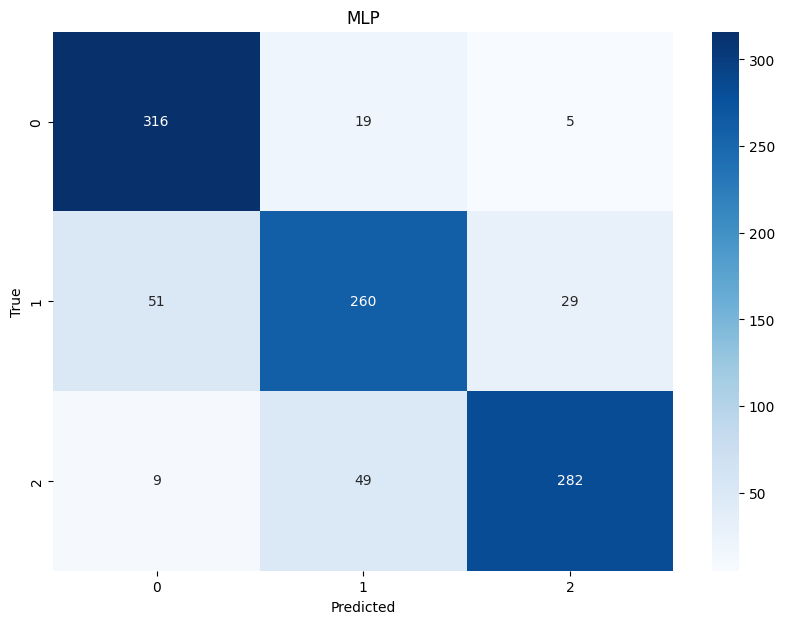

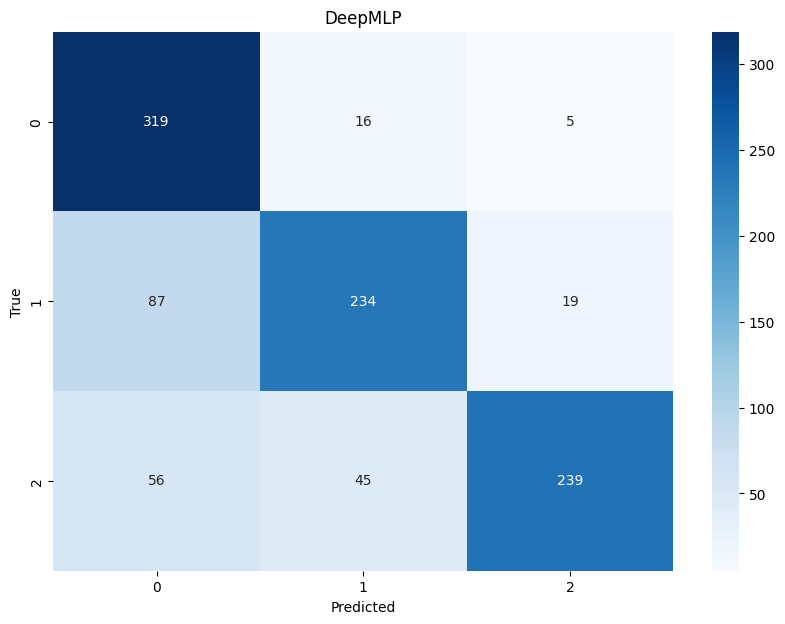

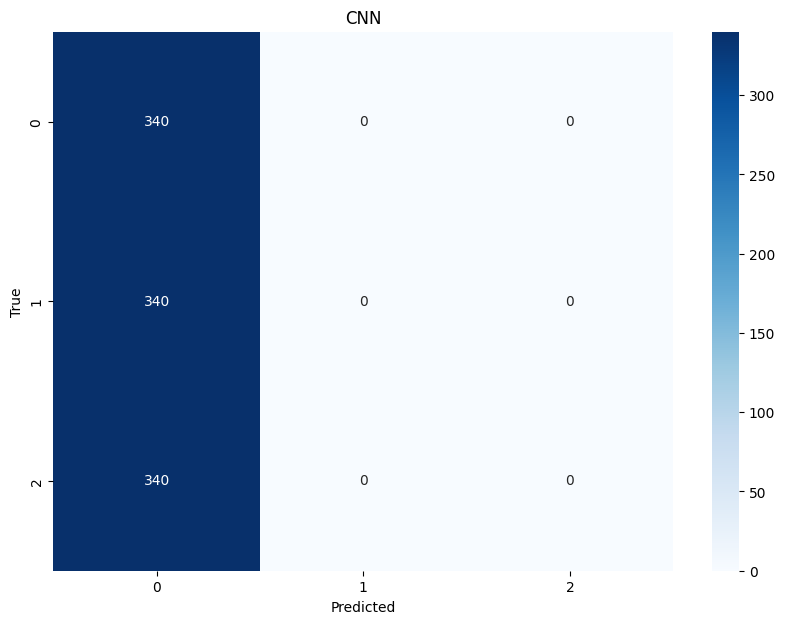

In [36]:
# plot the confusion matrix for models on the test set
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.utils import resample
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot the confusion matrix

    Args:
    y_true: np.array
    y_pred: np.array
    title: str
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    plt.show()

# we just resampled the test set to balance out the classes so that the confusion matrix is more interpretable
def balance_classes(X, y):
    """
    Balance the classes by oversampling the minority classes

    Args:
    X: torch.Tensor
    y: torch.Tensor

    Returns:
    X_balanced: torch.Tensor
    y_balanced: torch.Tensor
    """
    X_np = X.cpu().numpy()
    y_np = y.cpu().numpy()

    # Combine X and y for resampling
    data = np.hstack((X_np, y_np.reshape(-1, 1)))

    # Separate by class
    classes = np.unique(y_np)
    data_by_class = [data[data[:, -1] == cls] for cls in classes]

    # Find the maximum class size
    max_size = max(len(cls_data) for cls_data in data_by_class)

    # Resample each class to the maximum class size
    data_resampled = [resample(cls_data, replace=True, n_samples=max_size, random_state=SEED) for cls_data in data_by_class]

    # Combine resampled data
    data_balanced = np.vstack(data_resampled)

    # Separate X and y
    X_balanced = torch.tensor(data_balanced[:, :-1], dtype=torch.float32).to(DEVICE)
    y_balanced = torch.tensor(data_balanced[:, -1], dtype=torch.int64).to(DEVICE)

    return X_balanced, y_balanced

# Balance the test set
X_test_balanced, y_test_balanced = balance_classes(X_test, y_test)

# mlp
y_pred_mlp = best_mlp(X_test_balanced).argmax(dim=1).cpu().numpy()
plot_confusion_matrix(y_test_balanced.cpu().numpy(), y_pred_mlp, 'MLP')

# deepmlp
y_pred_deepmlp = best_deepmlp(X_test_balanced).argmax(dim=1).cpu().numpy()
plot_confusion_matrix(y_test_balanced.cpu().numpy(), y_pred_deepmlp, 'DeepMLP')

# cnn
y_pred_cnn = best_cnn(X_test_balanced).argmax(dim=1).cpu().numpy()
plot_confusion_matrix(y_test_balanced.cpu().numpy(), y_pred_cnn, 'CNN')

## Baseline Models (SKLearn)

For our baselines we made use of models implemented from the Sci-kit Learn Library

### Dummy Classifier

In [37]:
# baseline dummy model
from sklearn.dummy import DummyClassifier


dummy = DummyClassifier(strategy="uniform", random_state=0)
dummy.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = dummy.predict(X_test.cpu().numpy())
y_pred_val = dummy.predict(X_val.cpu().numpy())
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
accuracy_val = accuracy_score(y_val.cpu().numpy(), y_pred_val)
print('Dummy Baseline')
print("TEST")
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test.cpu().numpy(), y_pred))
print("VALIDATION")
print(f'Accuracy: {accuracy_val:.4f}')
print(classification_report(y_val.cpu().numpy(), y_pred_val))


Dummy Baseline
TEST
Accuracy: 0.3967
              precision    recall  f1-score   support

           1       0.83      0.37      0.51       340
           2       0.19      0.53      0.28        53
           3       0.12      0.45      0.19        33

    accuracy                           0.40       426
   macro avg       0.38      0.45      0.33       426
weighted avg       0.70      0.40      0.46       426

VALIDATION
Accuracy: 0.3471
              precision    recall  f1-score   support

           1       0.77      0.38      0.51       129
           2       0.16      0.35      0.22        23
           3       0.04      0.11      0.05        18

    accuracy                           0.35       170
   macro avg       0.32      0.28      0.26       170
weighted avg       0.61      0.35      0.42       170



### Logistic Regression Model

In [38]:
# baseline logistic regression
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, random_state=0)
logreg.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = logreg.predict(X_test.cpu().numpy())
y_pred_val = logreg.predict(X_val.cpu().numpy())
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
accuracy_val = accuracy_score(y_val.cpu().numpy(), y_pred_val)
print('Logistic Regression Baseline')
print("TEST")
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test.cpu().numpy(), y_pred))
print("VALIDATION")
print(f'Accuracy: {accuracy_val:.4f}')
print(classification_report(y_val.cpu().numpy(), y_pred_val))

Logistic Regression Baseline
TEST
Accuracy: 0.8826
              precision    recall  f1-score   support

           1       0.95      0.94      0.95       340
           2       0.58      0.58      0.58        53
           3       0.69      0.76      0.72        33

    accuracy                           0.88       426
   macro avg       0.74      0.76      0.75       426
weighted avg       0.88      0.88      0.88       426

VALIDATION
Accuracy: 0.8824
              precision    recall  f1-score   support

           1       0.90      0.96      0.93       129
           2       0.76      0.57      0.65        23
           3       0.87      0.72      0.79        18

    accuracy                           0.88       170
   macro avg       0.84      0.75      0.79       170
weighted avg       0.88      0.88      0.88       170



### Deep Multi-layer Perceptron

In [39]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(512, 256, 128, 64, 32), max_iter=1000, random_state=0)
mlp.fit(X_train.cpu().numpy(), y_train.cpu().numpy())
y_pred = mlp.predict(X_test.cpu().numpy())
y_pred_val = mlp.predict(X_val.cpu().numpy())
accuracy = accuracy_score(y_test.cpu().numpy(), y_pred)
accuracy_val = accuracy_score(y_val.cpu().numpy(), y_pred_val)
print('MLP Classifier Baseline')
print("TEST")
print(f'Accuracy: {accuracy:.4f}')
print(classification_report(y_test.cpu().numpy(), y_pred))
print("VALIDATION")
print(f'Accuracy: {accuracy_val:.4f}')
print(classification_report(y_val.cpu().numpy(), y_pred_val))

MLP Classifier Baseline
TEST
Accuracy: 0.9249
              precision    recall  f1-score   support

           1       0.96      0.96      0.96       340
           2       0.70      0.79      0.74        53
           3       0.96      0.79      0.87        33

    accuracy                           0.92       426
   macro avg       0.87      0.85      0.86       426
weighted avg       0.93      0.92      0.93       426

VALIDATION
Accuracy: 0.9529
              precision    recall  f1-score   support

           1       0.97      0.98      0.98       129
           2       0.84      0.91      0.88        23
           3       1.00      0.78      0.88        18

    accuracy                           0.95       170
   macro avg       0.94      0.89      0.91       170
weighted avg       0.96      0.95      0.95       170



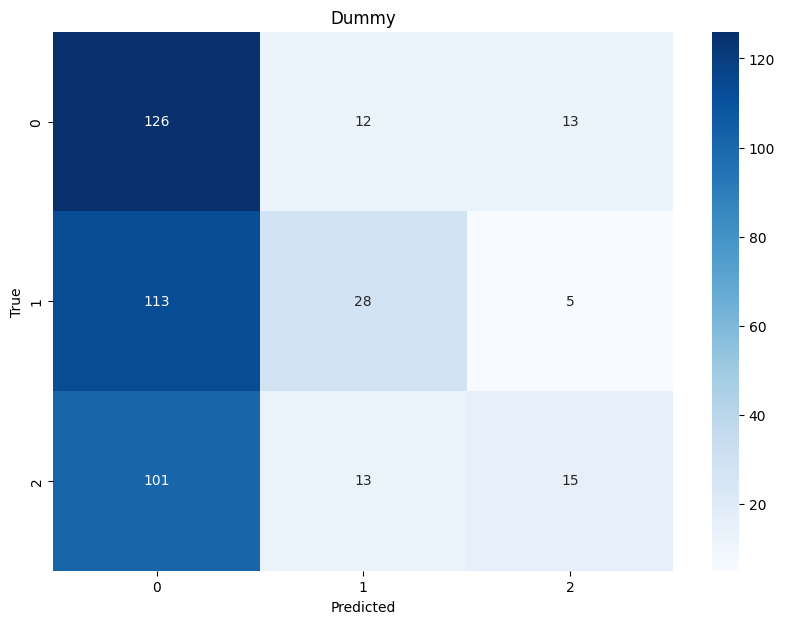

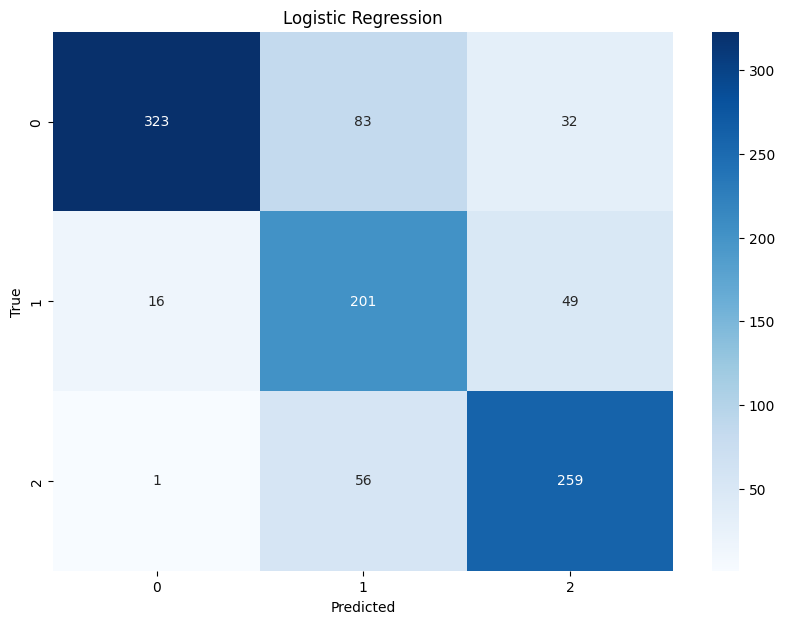

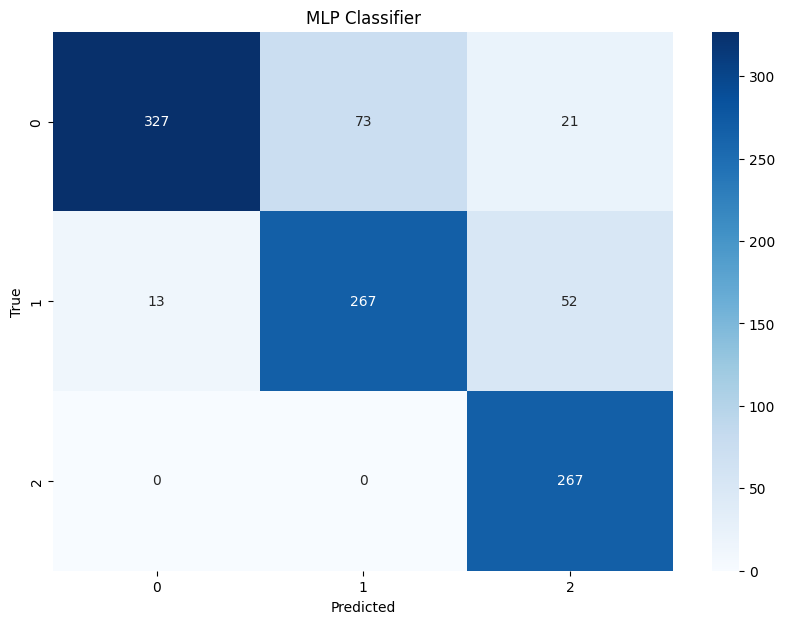

In [44]:
# confusion matrix for the dummy model
plot_confusion_matrix(dummy.predict(X_test.cpu().numpy()), y_test.cpu().numpy(), 'Dummy')

# confusion matrix for the logistic regression
plot_confusion_matrix(logreg.predict(X_test_balanced.cpu().numpy()), y_test_balanced.cpu().numpy(), 'Logistic Regression')

# confusion matrix for the mlp classifier
plot_confusion_matrix(mlp.predict(X_test_balanced.cpu().numpy()), y_test_balanced.cpu().numpy(), 'MLP Classifier')

In [45]:
# save the models
if SAVE_BEST_MODELS:
    if not os.path.exists('models'):
        os.makedirs('models')
    torch.save(best_mlp.state_dict(), 'models/best_mlp.pth')
    torch.save(best_deepmlp.state_dict(), 'models/best_deepmlp.pth')
    torch.save(best_cnn.state_dict(), 'models/best_cnn.pth')
    print('Models saved in models/best_mlp.pth, models/best_deepmlp.pth, models/best_cnn.pth')
